In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from mprompt.modules.fmri_module import SAVE_DIR_FMRI
import imodelsx.util
from mprompt.modules.emb_diff_module import EmbDiffModule
import scipy.stats
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
num_top_test_ngrams = 75
# r = (pd.read_pickle('../results/results_fmri.pkl')
    # .sort_values(by=['top_score_synthetic'], ascending=False))
r = (pd.read_pickle('../results/results_fmri_full.pkl')
    .sort_values(by=['top_score_synthetic'], ascending=False))
# r = r[r.subject == 'UTS02']


In [ ]:
columns = {
    # fmri stuff
    'subject': 'Subject',
    'module_num': 'Voxel',
    'roi_func': 'ROI (functional)',
    'roi_anat': 'ROI (anatomical)',
    'fmri_test_corr': 'Correlation (test)',
    
    # scores
    'top_score_synthetic': 'Synthetic data score',
    'frac_top_ngrams_module_correct': 'Fraction of matching ngrams (module, top-75)',
    'rankcorr_expl_test': 'Correlation (test) when predicting with only explanation',
    # 'frac_top_ngrams_test_correct': 'Fraction of matching ngrams (test, top-75)',
            
    # explanation
    'top_explanation_init_strs': 'Explanation',
        
    # ngrams matching the explanation (used 75 ngrams)
    'top_ngrams_module_correct': 'Matching top ngrams (out of top-75)',
    # 'top_ngrams_test_correct': 'Matching ngrams (test, top-75)',

    # all ngrams
    'top_ngrams_module_25': 'All top ngrams (top-25)',
    # 'top_ngrams_test_25': 'Top ngrams (test, top-25)',

    # alternative explanations
    'explanation_init_strs': 'Explanation candidates',
}

tab = (
    r
    .sort_values(by=['top_score_synthetic'], ascending=False)
    # .sort_values(by=['rankcorr_expl_test'], ascending=False)
    .filter(columns.keys())
    .rename(columns=columns)
    .round(3)
)
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    display(
        tab.head(3)
    )
    tab_join_lists = tab.applymap(lambda x: ' __ '.join(x) if isinstance(x, np.ndarray) or isinstance(x, list) else x)
    tab_join_lists.to_csv('../results/results_fmri.csv', index=False, float_format='%.3f')

### Overarching stats

In [ ]:
rt = r[['top_score_normalized', 'rankcorr_expl_test']]
# rt = rt.sort_values('fmri_test_corr', ascending=False)
print(rt.mean())
print(rt.std() / np.sqrt(rt.shape[0]))

In [ ]:
dsets = joblib.load(join(SAVE_DIR_FMRI, 'stories', 'running_words.jbl'))

In [129]:
spearmans = []
pearsons = []
cvs = []
# test different prediction mappings
for i in tqdm(range(r.shape[0])):
    row = r.iloc[i]
    resp = dsets[row["subject"]]["resp"][:, row["module_num"]]
    neg_dists = np.array(row["neg_dists_expl_test"])
    neg_dists[np.isnan(neg_dists)] = np.nanmean(neg_dists)

    # stack neg_dists with delays
    neg_dists_arr = np.stack(
        [
            np.concatenate((neg_dists[i:], np.ones(i) * np.nanmean(neg_dists)))
            for i in range(3)
        ]
    ).T
    # print(neg_dists_arr.shape, resp.shape)
    neg_dists = np.mean(neg_dists_arr, axis=1)
    
    spearmans.append(
        scipy.stats.spearmanr(
            neg_dists, resp, nan_policy="omit", alternative="greater"
        ).statistic
    )
    # pearson correlation
    pearsons.append(scipy.stats.pearsonr(neg_dists, resp)[0])

    # m = RidgeCV(alphas=10, scoring='r2')
    # m.fit(neg_dists_arr, resp)
    # neg_dists = m.predict(neg_dists_arr)
    # cvs.append(m.best_score_)
    cvs.append(0)
    # cvs.append(scipy.stats.pearsonr(neg_dists, resp)[0])
    # cvs = 
print("means", np.mean(spearmans), np.mean(pearsons), np.mean(cvs))
r['rankcorr_expl_test'] = spearmans

100%|██████████| 1000/1000 [00:01<00:00, 773.45it/s]

means 0.03290850500714539 0.032717674795117856 0.0


<>:7: DeprecationWarning: invalid escape sequence '\p'
<>:7: DeprecationWarning: invalid escape sequence '\p'
/tmp/ipykernel_84161/3417988278.py:7: DeprecationWarning: invalid escape sequence '\p'
  mean_and_std_err_string = f"Mean: {r['rankcorr_expl_test'].mean():.3f} $\pm$ {r['rankcorr_expl_test'].std() / np.sqrt(r['rankcorr_expl_test'].size):.3f}"


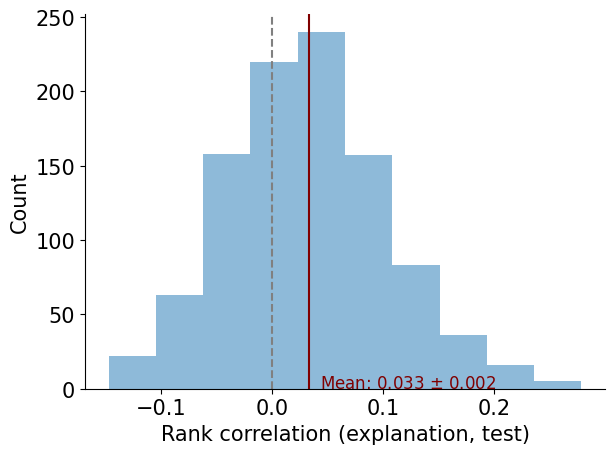

In [130]:
plt.hist(r['rankcorr_expl_test'], alpha=0.5) #, bins=20)
plt.axvline(0, color='gray', linestyle='dashed')
plt.ylabel('Count')

# draw vertical line at mean and add text label
plt.axvline(r['rankcorr_expl_test'].mean(), color='maroon')
mean_and_std_err_string = f"Mean: {r['rankcorr_expl_test'].mean():.3f} $\pm$ {r['rankcorr_expl_test'].std() / np.sqrt(r['rankcorr_expl_test'].size):.3f}"
plt.text(r['rankcorr_expl_test'].mean() + 0.01, 0.5, mean_and_std_err_string, rotation=0, fontsize=12, color='maroon')
plt.xlabel('Rank correlation (explanation, test)')
plt.show()

# with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
#     display(
#         r.sort_values(by=['rankcorr_expl_test'], ascending=False)[['top_explanation_init_strs', 'rankcorr_expl_test', 'roi_func', 'fmri_test_corr', 'subject']].head(20)
#     )

### Visualize how things relate to each other

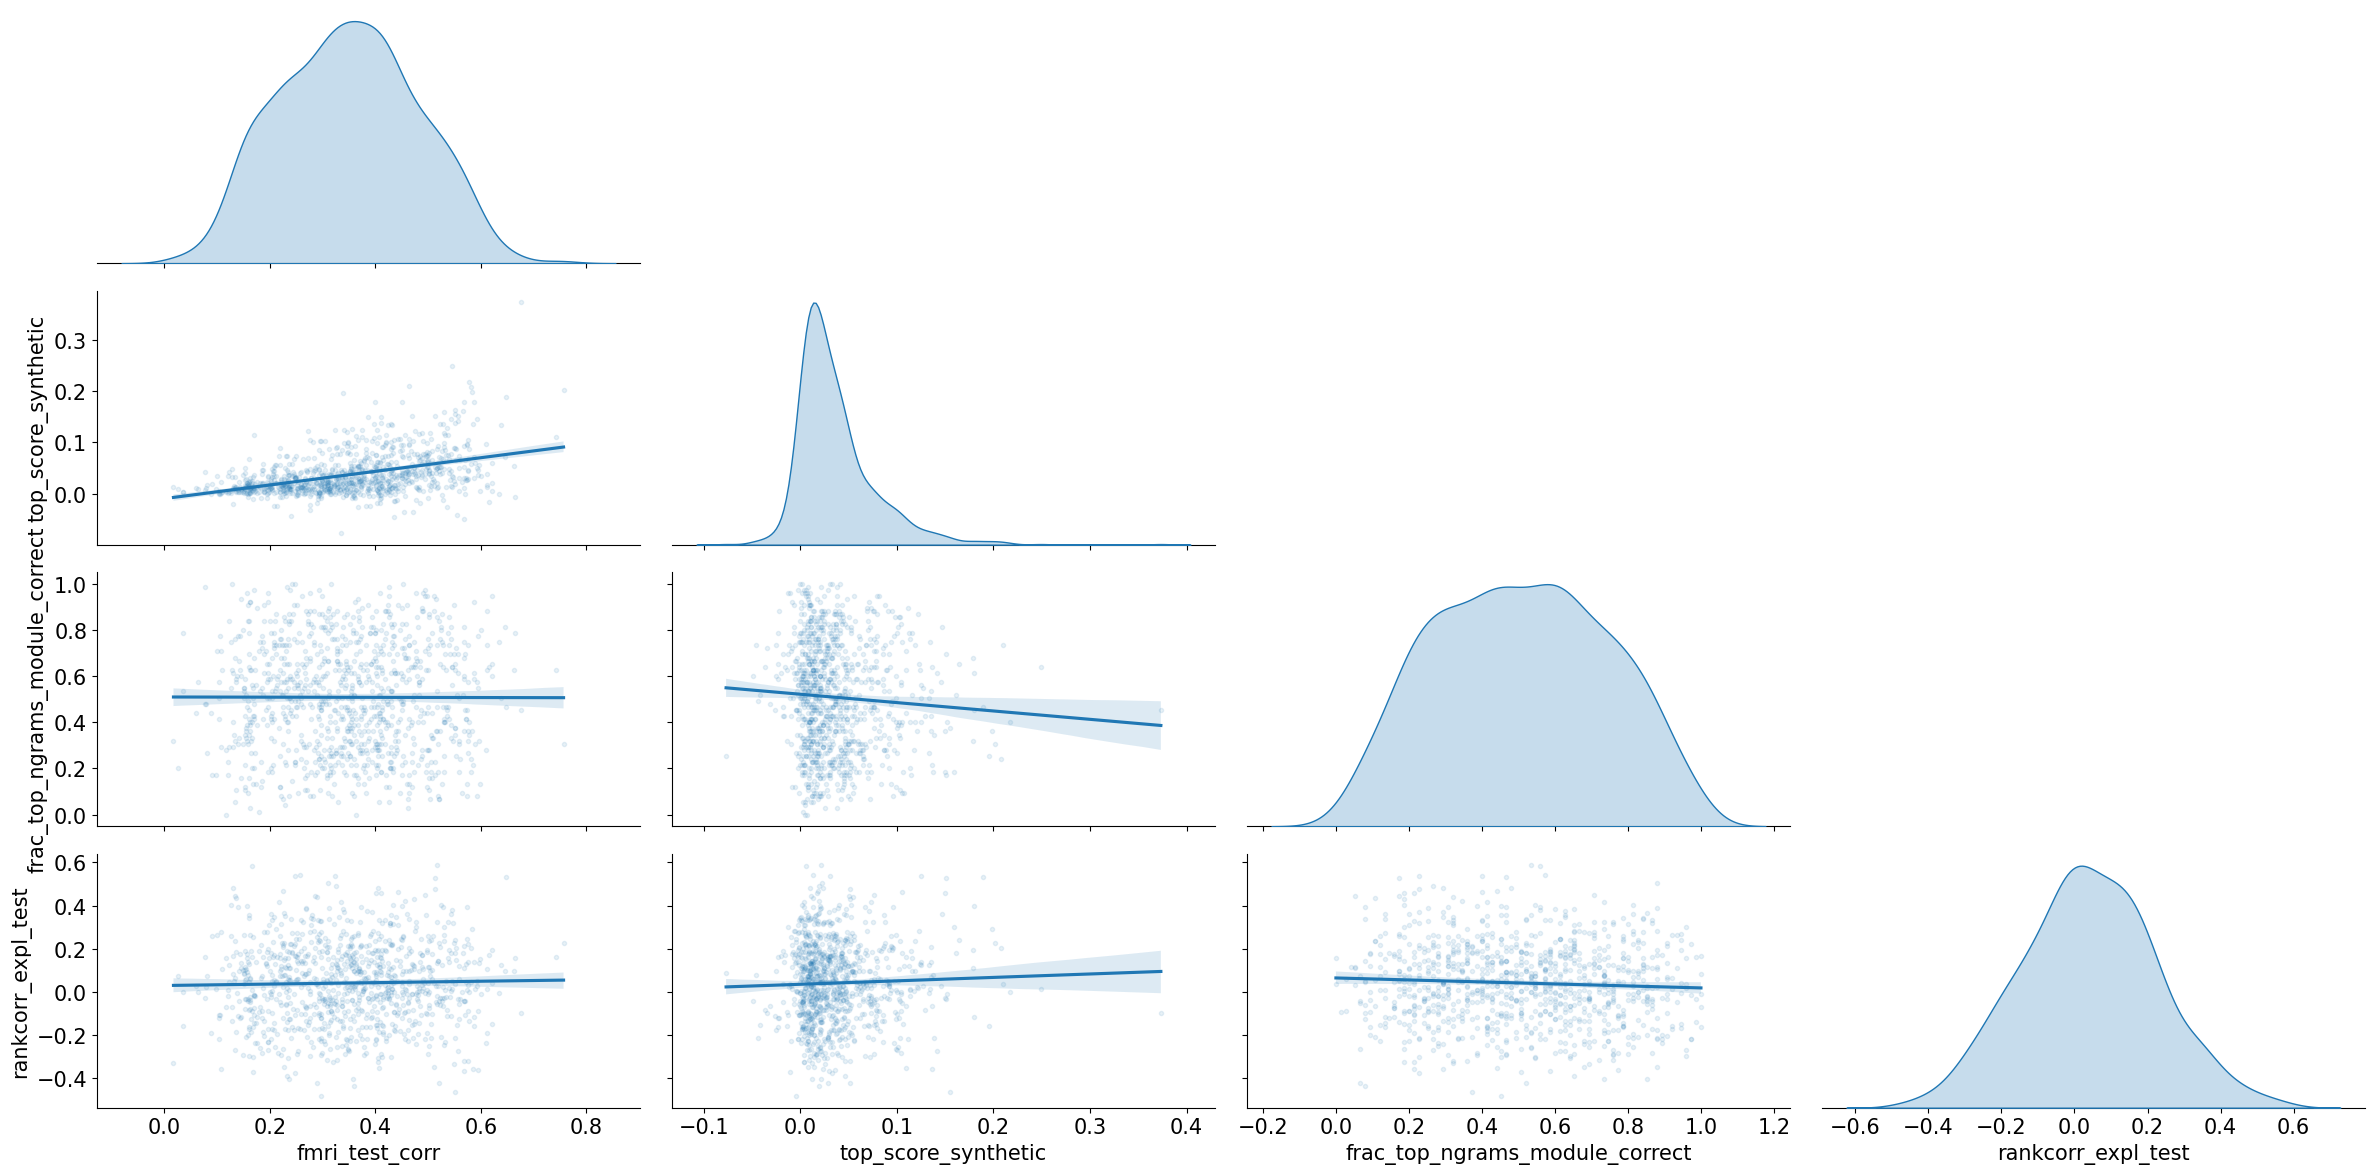

In [103]:
scores = ['fmri_test_corr', 'top_score_synthetic', 'frac_top_ngrams_module_correct', 'rankcorr_expl_test']
sns.pairplot(
    r[scores], kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.1}}, markers='.',
    height=3, aspect=2,
    corner=True
    )
plt.show()